# Bayesian Inference + MCMC 

This is the final part of my Master's thesis, where try to infer values of the most probable cosmological parameters for our generated data by using the Bayesian formula. Coupling this with Monte Carlo Markov Chain, one can evaluate numbers of data points, as the algorithm progress towards higher probability values.

This notebook was originally written by my supervisor, Asst. Prof. Jose M.E., and I have put it to use by trying to fit a few new cosmological parameters for the first time. 

This notebook is one of the four copies of the original code. Where each of them are used to fit different cosmological parameters. Where this one is $\Omega_k$. (Scroll down to see what these parameters mean.) 

## What are we looking for exactly?

This thesis is about gravitational waves(GW), and what can GW data tell us about the universe ?
GW are generated when massive objects such as black holes or neutron stars orbit around each other, they create ripple in space-time that travel at the speed of light; these ripples are GWs.

Sources of GW such as black holes(BH) are studied. Different BHs generate different GWs depending how far they are and how massive they are. Expansion rate of the universe can also change the amplitude of GWs detected on earth! If we look at a large number of population og BH from various distances from earth, we can see a pattern of their evolution and so we can study the cosmology from that.

With the convenience of methematical simulation; we can generate realistic data of detected GW signals that came from BH coallescense. This is important because we can control the number of detections to as much as we want, and plug them into our MCMC algorithm.  

#### TLDR
:The code in this file will give us the property of the universe in terms of cosmological parameters. These output are the best fit for the simulated data. 
___
The detection of GW is still new and the building of detectors are on-going. Results from simulated data can be used to make prediction on the future of detection. After all, the goal of my thesis was to see how good GWs are, as a tool of studying cosmology.


_______________

## Bayesian statistics
The bayesian approach to statistic is invaluable in all sciences in modern times. It describes hypothesis and data as a probability distribution, and accounts for their uncertainty.
 
#### Bayes' Theorem
is the heart of the bayesian inference algorithm. The formula states the relationship between the posterior and the combination of prior knowledge and observations. 
This is expressed as:

## $ p(\theta|x)=\frac{p(x|\theta)p(\theta)}{p(x)} $

Where $p(\theta|x) =$ posterior; probability of hypothesis given the evidence

$p(x|\theta) =$ likelihood function

$p(\theta) =$ prior (knowledge about $\theta$)

$p(x)=$ evidence or observation


$x$ are data generated from a probability distribution with an
unknown parameter $θ$.

After data $x$ is generated, a prior can then be updated. This step is repeated and a posterior distribution is better determined.

### MCMC
In our program, we coupled this with a Monte Carlo Markov Chain (MCMC) algorithm. It uses multiple walkers that can simultaneously explore a probability space within a given range. With each iteration steps, they check if the likelihood of the new value is better, then update the prior and takes the path with better likelihood. As a result, they move closer and closer towards a value with best outcome.

#### In the end, the posterior is what we want to know!

In [1]:
# Here we import modules necessary to make MCMC run(fast)

import numpy as np

#Numpyro and friends
import numpyro
from numpyro.infer import NUTS,MCMC
import numpyro.distributions as dist
from jax import random
from jax import jit
from jax.config import config
import jax.numpy as jnp
from jax.scipy.special import erf
import arviz as az

config.update("jax_enable_x64", True)
nChains = 1
numpyro.set_host_device_count(nChains)

#PYTHON MODULES
from constants import *
from constants_gw import *
import jgwcosmo_Omk as jgwcosmo
import jgwpop

#PLOTS
import matplotlib.pyplot as plt
import corner
import sys
dir_base=sys.path[0]
dir_out=dir_base+"/plots_cosmo_mass_evolution/"

from matplotlib.ticker import ScalarFormatter
#%config InlineBackend.figure_format = 'retina'
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
fontSz = 15
fontsz = 13
fontssz = 11

---
## Fiducial universe parameters : $ p(x) $
These are the values that are well known in literature. (Therefore these are Evidence/ observation)

Cosmological parameters describe the property of the known population. 

### What do some of these mean?

$\Omega_k$ = Curvature of the universe 

w = a constant, that determine a dominated specie of the universe

$H_0$ = Hubble constant; describe the expansion

$\Omega_0$ = present day density parameter

$\alpha_z$,$\alpha,\beta,\sigma$ describe mass distribution of GW sources

In [2]:
#Fiducial universe
Omk_fid = 0.001 
w_fid   = -1.  
H0_fid  = 67.66     # Hubble constant from Planck'18
Om0_fid = 0.30966   # Omega at redshift 0
r0_fid  = 30.
alpha_z_fid = 1.
zp_fid      = 2.4
beta_fid = 3.4
mmin_fid = 10.
mmax_fid = 78.
kappa1_fid = 1.8
kappa2_fid = 5.
b_fid = 0.4
bq_fid = 0.0

alpha_fid = -2.7
sig_m1_fid = 7.
mu_m1_fid = 30.
f_peak_fid = 0.05
dmMax_fid = 2.
dmMin_fid = 1.

tmp_min = 2.
tmp_max = 150.

---
## Priors:    $p(\theta)$
Our input for the 'priors'. This is given as a range of values (i.e. a uniform distribution). Since the best fit parameters are not yet known, we are about the find out what they are ...

In [3]:
log10r0_min, log10r0_max = -3., 3.
#w_min, w_max             = -1.5, -0.5  
Omk_min, Omk_max         = -0.5, -0.001  
#h0_min, h0_max           = 0.4, 1.2   
Om0_min, Om0_max         = 0.1, 0.5
alpha_min, alpha_max     = 0., 25.
kappa1_min, kappa1_max   = -4., 12.
kappa2_min, kappa2_max   = -4., 12.
mmin_min, mmin_max       = 1., 20.
mmax_min, mmax_max       = 30., 100.
b_min, b_max             = 0., 1.
beta_min, beta_max       = 0., 10.
zp_min, zp_max           = 0., 4.
gamma_min, gamma_max     = -10, 10

---

---
### Here we can set the number of GW detections in our simulation

In [4]:
gamma1_fid = 0.       # Fiducial population without evolution
gamma2_fid = 0.

In [5]:
n_samples = 1
n_detections = 5000


---
## Generate mock data
These data are treated as 'detections'. This is generated by using Inverse Transform Sampling method. You can read about this in my other notebook!

In [6]:
""" Inverse Sampling """
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
def inverse_transf_sampling(cum_values,variable,n_samples):
    inv_cdf = interp1d(cum_values, variable)
    r = np.random.uniform(min(cum_values),max(cum_values),n_samples)
    return inv_cdf(r)

def mock_source_parameters(n_sources,Omk,H0,Om0,mmin,mmax,alpha,sig_m1,mu_m1,f_peak,zp,alpha_z,beta):
    zs = np.linspace(0.01,10.,10000)
    cdf_z = cumtrapz(jgwcosmo.diff_comoving_volume(zs,H0,Om0,Omk)*jgwpop.rate_z(zs,zp,alpha_z,beta)/(1+zs),zs,initial=0)
    cdf_z /= cdf_z[-1]
    
    masses = np.linspace(tmp_min,tmp_max,10000)
    cdf_m1 = cumtrapz(jgwpop.powerlaw_peak(masses,mmin,mmax,alpha,sig_m1,mu_m1,f_peak),masses,initial=0)
    # the power law of mass dist(2 peaks)
    cdf_m1 /= cdf_m1[-1]

    z_mock = inverse_transf_sampling(cdf_z,zs,n_sources)
    m1_mock = inverse_transf_sampling(cdf_m1,masses,n_sources)
    m2_mock = np.random.uniform(mmin,m1_mock,n_sources)
    #### dL_mock = jgwcosmo.dL_approx(z_mock,H0,Om0)
    #### = REPLACED APPROX FUNCTIONS
    dL_mock = jgwcosmo.d_L(z_mock,H0,Om0,Omk)
    m1z_mock = (1 + z_mock) * m1_mock
    m2z_mock = (1 + z_mock) * m2_mock
    return m1z_mock, m2z_mock, dL_mock

## Perfect measurement
Now we assume that we are performing a perfect measurement of GW. 
This means that, we only have one sample directly associated to the mock event

Hence ..

In [8]:
n_sources = n_detections

m1z_mock_CE, m2z_mock_CE, dL_mock_CE = mock_source_parameters(n_sources,Omk_fid,H0_fid,Om0_fid,mmin_fid,mmax_fid,alpha_fid,sig_m1_fid,mu_m1_fid,f_peak_fid,zp_fid,alpha_z_fid,beta_fid)

#THis is not really necessary because only 1 sample...but was introduced for the more general case
m1z_mock_samples_CE = np.zeros((n_detections,n_samples))
m2z_mock_samples_CE = np.zeros((n_detections,n_samples))
dL_mock_samples_CE = np.zeros((n_detections,n_samples))
jacob_mock_samples_CE = np.ones((n_detections,n_samples))
for i in range(n_detections):
    m1z_mock_samples_CE[i,:], m2z_mock_samples_CE[i,:], dL_mock_samples_CE[i,:] = m1z_mock_CE[i], m2z_mock_CE[i], dL_mock_CE[i]

their probability of detection were then determined.

Then we calculate likelihood

---
## Likelihood functions : $p(x|\theta)$
These consist of the theoretical population of GW sources (i.e. BHs), and the description of cosmology.

Logarithm functions are use so that small numbers can be handled easier.

In [9]:
def log_Rz(z,r0,zp,alpha,beta):
    c0 = jnp.log1p((1. + zp)**(-alpha-beta))
    num = (1.+z)**alpha
    den = 1. + ((1.+z)/(1.+zp))**(alpha+beta)
    return jnp.log(r0) + c0  + alpha*jnp.log1p(z) - jnp.log1p(jnp.power((1.+z)/(1.+zp),(alpha+beta)))


def log_cosmo(z,H0,Om0,Omk):
    dL   = jgwcosmo.d_L(z,H0,Om0,Omk) # Mpc
    Ez_i = jgwcosmo.Ez_inv(z,Om0,Omk)
    D_H  = (Clight/1e3)  / H0         # Mpc
    
    y2 = 1 - jnp.power( jnp.sin( dL*jnp.sqrt(jnp.abs(Omk))/(1+z)/D_H ), 2 )
    
    logdiff_comoving_volume = jnp.log(1.0e-9) + jnp.log(4*jnp.pi) + 2*jnp.log(dL) +jnp.log(D_H) +jnp.log(Ez_i)-2*jnp.log1p(z)
    ddLdz = dL/(1.+z) + (1/jnp.sqrt(y2))*(1. + z)*D_H * Ez_i #Mpc 
    logJacobian = jnp.log(jnp.abs(ddLdz))#Jac has absolute value 
    return logdiff_comoving_volume - jnp.log1p(z) - logJacobian 


def logNdet_events(m1,m2,z,p_draw,Omk,H0,Om0,r0,Tobs,zp,alpha_z,beta,mmin,mmax,alpha,sig_m1,mu_m1,f_peak,bq,Nsamples):
    #input data (N,M): N detections x M samples
    log_pm1 = jnp.log(jgwpop.powerlaw_peak(m1,mmin,mmax,alpha,sig_m1,mu_m1,f_peak)) - jnp.log1p(z) 
    log_pm2 = 0 #NOT adding this at the moment 
    log_pm = log_pm1 + log_pm2
    logcosmo = log_cosmo(z,H0,Om0,Omk)
    logRzs = log_Rz(z,r0,zp,alpha_z,beta) + jnp.log(Tobs)
    log_dN = log_pm + logcosmo + logRzs - jnp.log(p_draw)
    
    m = 0 
    return jnp.sum(m + jnp.log(jnp.sum(jnp.exp(log_dN-m),axis=1)) - jnp.log(Nsamples))

_Possible improvements_

- Only call dL once by computing the redshift normalization aty the same time
- 2D normaliztion for masses, 3D for mass evolution?


In [10]:
@jit
def log_lik(h0,Om0,Omk,mmin,mmax,alpha,mu_m1,sig_m1,f_peak,alpha_z,zp,beta):
    #Fixed parameters
    r0 = 1.0              # 10.**log10r0
    H0 = h0*100
    Tobs = 1.
    bq = bq_fid 
    
    Nobs, Nsamples = jnp.shape(m1z_mock_samples_CE)
    
    D_H = (Clight/1.0e3)  / H0 #Mpc
    
    m1_mock, m2_mock, z_mock = jgwcosmo.detector_to_source_frame(m1z_mock_samples_CE,m2z_mock_samples_CE,dL_mock_samples_CE,H0,Om0,Omk,zmin=1e-3,zmax=100)

    #Log_lik Events
    p_draw = jacob_mock_samples_CE
    loglik_E = logNdet_events(m1_mock,m2_mock,z_mock,p_draw,Omk,H0,Om0,r0,Tobs,zp,alpha_z,beta,mmin,mmax,alpha,sig_m1,mu_m1,f_peak,bq,Nsamples)

    zs_norm = jnp.linspace(0.01,10,1000) 
    ####
    dn_detec = jgwpop.rate_z(zs_norm,zp,alpha_z,beta)*jgwcosmo.diff_comoving_volume(zs_norm,H0,Om0,Omk)/(1.+zs_norm)   
    norm_z = jnp.trapz(dn_detec,zs_norm)
    loglik_E -= Nobs*jnp.log(norm_z)

    m1s_norm = jnp.linspace(tmp_min,tmp_max,1000)    
    norm_m1 = jnp.trapz(jgwpop.powerlaw_peak(m1s_norm,mmin,mmax,alpha,sig_m1,mu_m1,f_peak),m1s_norm)
    loglik_E -= Nobs*jnp.log(norm_m1)
    
    #Selection effects
    loglik_N = 0.
    
    return loglik_N + loglik_E

Sampling of prior data from above

In [11]:
def log_probability():
    
    #Priors
    #w = -1. #numpyro.sample("w",dist.Uniform(w_min,w_max))
    Omk = numpyro.sample("Omk0",dist.Uniform(Omk_min, Omk_max))
    h0 = 67.66/100  #numpyro.sample("h0",dist.Uniform(h0_min,h0_max))
    Om0 = numpyro.sample("Om0",dist.Uniform(Om0_min,Om0_max))
    mmin = numpyro.sample("mmin",dist.Uniform(mmin_min,mmax_max))
    mmax = numpyro.sample("mmax",dist.Uniform(mmax_min,mmax_max))
    alpha = numpyro.sample("alpha",dist.Normal(0,5))
    mu_m1 = numpyro.sample("mu_m1",dist.Uniform(20,60))
    sig_m1 = numpyro.sample("sig_m1",dist.Uniform(1,10))
    f_peak = numpyro.sample("f_peak",dist.Uniform(0,1))
    alpha_z = numpyro.sample("alpha_z",dist.Uniform(0,2))
    #Fixed
    zp = zp_fid #numpyro.deterministic('zp',zp_fid)
    beta = beta_fid #numpyro.deterministic('beta',beta_fid)
    #bq = numpyro.sample("bq",dist.Normal(0,5)) #when fitting m_2

    #Likelihood
    numpyro.factor("logp",log_lik( h0,Om0,Omk, mmin, mmax,alpha,mu_m1,sig_m1,f_peak,alpha_z,zp,beta))


In [12]:
rng_key = random.PRNGKey(2)
rng_key,rng_key_ = random.split(rng_key)

In [13]:
# Set up NUTS sampler over our likelihood

kernel = NUTS(log_probability)

mcmc = MCMC(kernel,num_warmup=100,num_samples=300,num_chains=nChains,chain_method='parallel')

Now we can finally run the MCMC here:

In [14]:
mcmc.run(rng_key_)#, init_params=jnp.array([H0_fid/100, mmin_fid,mmax_fid,-2.7,5,30.,0.05])
mcmc.print_summary()
samples = mcmc.get_samples()

print('Fiducial values:')
print('H0=',H0_fid,', Om0=',Om0_fid)
print('w=',w_fid,'alpha=',alpha_fid,', bq=',bq_fid,', f_peak=',f_peak_fid,', mmax=',mmax_fid,', mmin=',mmin_fid,', mu_m1=',mu_m1_fid,', sig_m1=',sig_m1_fid)
print('alpha_z=',alpha_z_fid,', zp=',zp_fid,', beta=',beta_fid)



sample: 100%|█| 400/400 [12:19<00:00,  1.85s/it, 15 steps of size 4.90e-02. acc.



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       Om0      0.31      0.01      0.32      0.29      0.34    149.75      1.00
      Omk0     -0.00      0.00     -0.00     -0.00     -0.00    370.04      1.00
     alpha     -2.76      0.06     -2.75     -2.86     -2.67    325.52      1.00
   alpha_z      1.04      0.09      1.05      0.92      1.20    208.33      1.00
    f_peak      0.05      0.00      0.05      0.04      0.05    426.42      1.00
      mmax     77.50      1.07     77.34     76.15     79.50     80.36      1.01
      mmin     10.02      0.06     10.02      9.92     10.11    234.77      1.00
     mu_m1     30.04      0.31     30.04     29.56     30.59    210.84      1.00
    sig_m1      6.92      0.21      6.93      6.54      7.26    120.06      1.00

Number of divergences: 0
Fiducial values:
H0= 67.66 , Om0= 0.30966
w= -1.0 alpha= -2.7 , bq= 0.0 , f_peak= 0.05 , mmax= 78.0 , mmin= 10.0 , mu_m1= 30.0 , sig_m1= 7.0
alpha_z= 1.0 , zp= 2.4

### Presenting the results (posterior)

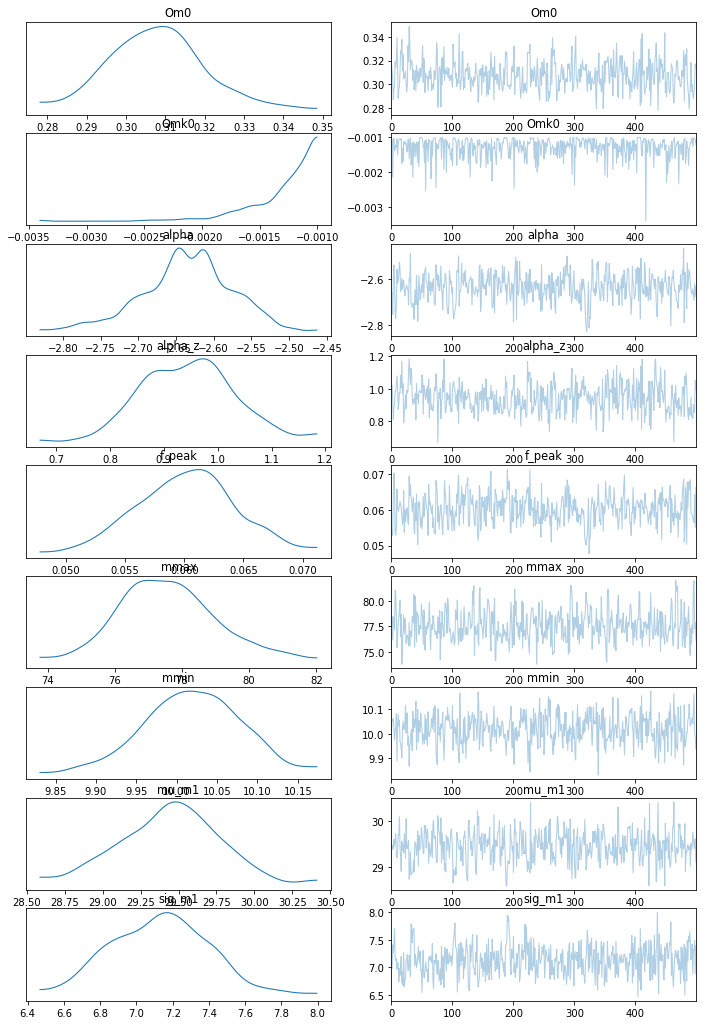

In [16]:
az.plot_trace(mcmc)#, compact=True)
#plt.tight_layout()
#plt.savefig('chain_Omk_1100new.png')
plt.show()

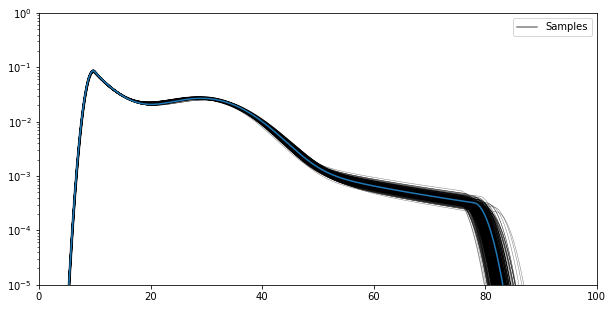

In [122]:
fig,ax = plt.subplots(figsize=(10,5))

m1_grid = np.linspace(2,150,1000)

random_inds = np.random.choice(np.arange(samples['mmax'].size),size=500)
for i in random_inds:
    
    p_m1 = jgwpop.powerlaw_peak(m1_grid,
                            samples['mmin'][i],
                           samples['mmax'][i],
                           samples['alpha'][i],
                            samples['sig_m1'][i],
                            samples['mu_m1'][i],
                            samples['f_peak'][i])
    p_m1 /= np.trapz(p_m1,m1_grid)
    
    ax.plot(m1_grid,p_m1,color='black',lw=0.5,alpha=0.5)

massess = np.linspace(2,150,1000)
pm_true = jgwpop.powerlaw_peak(massess,mmin_fid,mmax_fid,alpha_fid,sig_m1_fid,mu_m1_fid,f_peak_fid)
pm_true /= jnp.trapz(pm_true,massess)

ax.plot([],'k',alpha=0.5,label='Samples')
ax.semilogy(massess,pm_true)#,label='True')    


ax.set_yscale('log')
ax.set_ylim(1e-5,1)
ax.set_xlim(0,100)
#plt.savefig('mass_Omk_1100.png')
plt.legend()
plt.show()

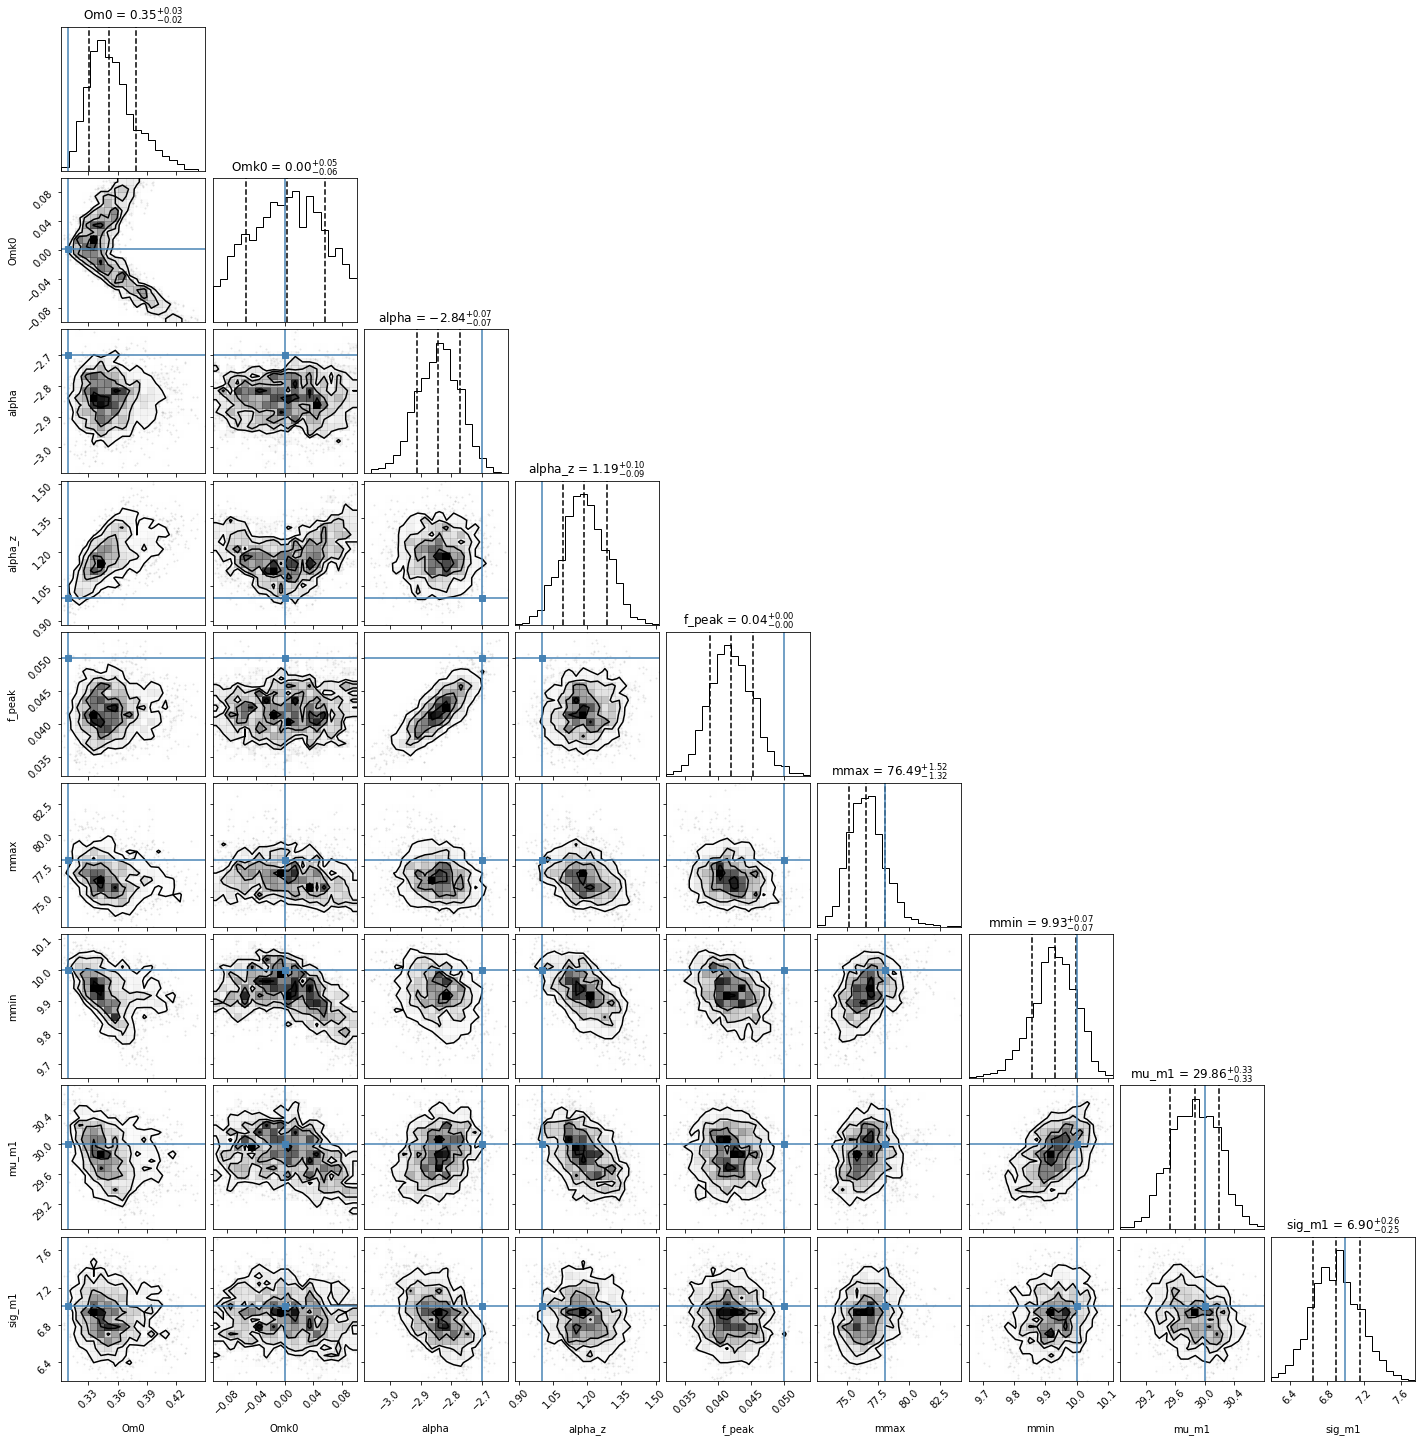

In [20]:
fig = corner.corner(
    samples,quantiles=[0.16, 0.5, 0.84],#, labels=labels
                       show_titles=True,fontsize=fontsz,
    truths=[Om0_fid,Omk_fid,alpha_fid,alpha_z_fid,f_peak_fid,mmax_fid,mmin_fid,mu_m1_fid,sig_m1_fid]#, truths=[H0_fid/100,alpha_ml, zp_ml]
);
plt.savefig('corner_Omk_2500new.png')
plt.show()